In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatial_maps as sp
import head_direction as hd
import septum_mec.analysis.data_processing as dp
import expipe
import os
import pathlib
import math
import numpy as np
import exdir
from scipy.interpolate import interp1d
import pandas as pd
from matplotlib import gridspec
import quantities as pq
import elephant as el
import speed_cells.speed as spd
from septum_mec.analysis.plotting import plot_bootstrap_timeseries, despine
import seaborn as sns
import neo

06:30:37 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
position_sampling_rate = 100 # for interpolation
position_low_pass_frequency = 6 # for low pass filtering of position
max_speed = 1 # m/s only used for speed score
min_speed = 0.02 # m/s only used for speed score
binsize = 0.02 # for rate map and speed
smoothing = 0.03
velocity_threshold = 5


plt.rcParams['figure.figsize'] = (16,9)
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize') or
        k.endswith('titlesize')
    )
})

In [4]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [5]:
def spatial(x, y, t, sptr, a, at, binsize, smoothing, fig, gs, t_start=None, t_stop=None):
    mask_zero_occupancy = False
    
    if t_start is not None and t_stop is not None:
        mask = (t < t_stop) & (t > t_start)
        x, y, t = x[mask], y[mask], t[mask]
        sptr = neo.SpikeTrain(
            sptr.times[(sptr.times > t_start) & (sptr.times < t_stop)],
            t_start=t_start, t_stop=t_stop, **sptr.annotations
        )
    
    gs0 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs)
    
    spatial_map = sp.SpatialMap(
        x, y, t, sptr, box_size=1.0, bin_size=binsize)
    
    rate_map = spatial_map.rate_map(smoothing=smoothing, mask_zero_occupancy=mask_zero_occupancy)
    
    axs = [fig.add_subplot(g, projection='polar' if i == 2 else None) for i, g in enumerate(gs0)]
    axs[0].imshow(rate_map, vmin=0)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[0].set_title('gridness {:.2f}'.format(sp.gridcells.gridness(rate_map)))
    
    axs[1].plot(x, y, 'k', alpha=0.3)
    # Remove spikes that fall outside the range of times.
    # Otherwise, interpolation will fail when plotting spikes in scatter plot.
    sptr = sptr[(sptr > min(t)) & (sptr < max(t))]
    x_spike = interp1d(t,x)(sptr)
    y_spike = interp1d(t,y)(sptr)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].scatter(x_spike, y_spike, marker='.', color=(0.7, 0.2, 0.2), s=2)
    axs[1].set_ylim(1,0)
    axs[1].set_title('N spikes {}'.format(len(sptr)))
    
#     np.nan_to_num(rate_map, copy = False) # inplace
#     autocorr = sp.tools.fftcorrelate2d(rate_map, rate_map, mode = 'full', normalize = True)
#     axs[2].imshow(autocorr, vmin=0)
#     axs[2].set_xticks([])
#     axs[2].set_yticks([])
    
    ang_bins, rate_ang = hd.head_direction_rate(sptr, a, at)
    hd_dir, hd_score = hd.head_direction_score(ang_bins, rate_ang)
    hd_dir = math.degrees(hd_dir)
    binsize = ang_bins[1] - ang_bins[0]
    axs[2].set_xticks([0, np.pi])
    axs[2].bar(ang_bins, rate_ang, width=binsize, color='b')
    axs[2].set_title('hd {:.2f}, {:.1f} deg'.format(hd_score, hd_dir))
    
    for ax in axs:
        ax.set_aspect(1)

In [46]:
def spikelfp(sptr, anas, fig, gs, t_start=None, t_stop=None, f_start=None, f_stop=None):
    
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs)
    axs = [fig.add_subplot(g) for g in gs0]
    
    sampling_rate = anas.sampling_rate.magnitude
    
    times = np.arange(0, anas.shape[0] / sampling_rate, 1 / sampling_rate) * pq.s
    
    t_start = t_start * pq.s if t_start is not None else 0 * pq.s
    sampling_rate = anas.sampling_rate
    anot = anas.annotations
    units = anas.units
    if t_start is not None and t_stop is not None:
        t_stop = t_stop * pq.s
        mask = (times > t_start) & (times < t_stop)
        times = times[mask]
        anas = np.array(anas)[mask,:]
        sptr = neo.SpikeTrain(
            sptr.times[(sptr.times > t_start) & (sptr.times < times[-1])],
            t_start=t_start, t_stop=times[-1],
            **sptr.annotations
        )
    anas, _ = select_and_clean(anas)
    anas = neo.AnalogSignal(
        signal=anas * units, sampling_rate=sampling_rate, t_start=t_start,
        **anot    
    )

    sigs, freqs = el.sta.spike_field_coherence(anas, sptr, **{'nperseg': 2048})
    
    for sig, ch in zip(sigs.T, anot['electrode_idx']):
        axs[0].plot(freqs, sig, label='ch {}'.format(ch))
    axs[0].legend(frameon=False, ncol=2)
    if f_start is not None and f_stop is not None:
        axs[0].set_xlim(f_start, f_stop)
    axs[0].set_ylabel('lfp coherence')
    despine(axs[0], xticks=False)

    sampling_rate = sampling_rate.magnitude
    bins = np.arange(
        sptr.t_start.magnitude, sptr.t_stop.magnitude, 1 / sampling_rate) #time bins for spikes
    #firing rate histogram
    hist = np.histogram(sptr, bins=bins)[0].astype(float)
    hist -= hist.mean()
    axs[1].psd(hist, Fs=sampling_rate, NFFT=2048)
    if f_start is not None and f_stop is not None:
        axs[1].set_xlim(f_start, f_stop)
    axs[1].set_ylabel('spike psd')

In [51]:
def speedcor(speed, t, spike_times, min_speed, max_speed, binsize, fig, gs, t_start=None, t_stop=None):
    
    if t_start is not None and t_stop is not None:
        mask = (t < t_stop) & (t > t_start)
        x, y, t = x[mask], y[mask], t[mask]
        spike_times = neo.SpikeTrain(
            spike_times.times[(spike_times.times > t_start) & (spike_times.times < t_stop)],
            t_start=t_start, t_stop=t_stop, **spike_times.annotations
        )
    
    gs0 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs)
    ax = fig.add_subplot(gs0[0])  
    
    speed_score, inst_speed, rate, times = spd.speed_correlation(
        speed, t, spike_times, return_data=True)
    
    speed_bins = np.arange(min_speed, max_speed + binsize, binsize)
    ia = np.digitize(inst_speed, bins=speed_bins, right=True)
    rates = []
    
    for i in range(len(speed_bins)):
        rates.append(rate[ia==i])
        
    ax.set_title('speed score {:.3f}'.format(speed_score))
    plot_bootstrap_timeseries(speed_bins, rates, ax=ax)
    ax.set_xlabel('Speed m/s')
    ax.set_ylabel('Rate spikes/s')
    
#     mean_rate = [np.mean(r) for r in rates]
#     aspect = (max_speed - min_speed) / (np.nanmax(mean_rate) - np.nanmin(mean_rate))
#     ax.set_aspect(aspect)

In [69]:
def psth(sptr, stim_times, fig, gs, pre_stim, post_stim, binsize, t_start=None, t_stop=None):
    
    if t_start is not None and t_stop is not None:
        stim_times = stim_times[(stim_times > t_start) & (stim_times < t_stop)]
        sptr = neo.SpikeTrain(
            sptr.times[(sptr.times > t_start) & (sptr.times < t_stop)],
            t_start=t_start, t_stop=t_stop, **sptr.annotations
        )
    
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs)
    axs = [fig.add_subplot(g) for g in gs0]
    
    spike_times = sptr.magnitude
    trials = [
        spike_times[(spike_times > t + pre_stim) & (spike_times <= t + post_stim)] - t 
        for t in stim_times
    ]
    trials_ids = [[i]*len(t) for i, t in enumerate(trials)]

    trials_flat = [s for t in trials for s in t]
    trials_ids_flat = [s for t in trials_ids for s in t]
    axs[1].scatter(trials_flat, trials_ids_flat, s=.5)
    axs[1].set_xlim(pre_stim, post_stim)
    axs[1].set_xlabel('relative stim time')
    
    bins = np.arange(pre_stim, post_stim + binsize, binsize)
    hist, bins = np.histogram(trials_flat, bins=bins)
    hist = (hist / binsize) / len(stim_times)
    axs[0].bar(bins[:-1], hist, width=-binsize, align='edge');
    axs[0].set_xlim(pre_stim, post_stim)
    despine(axs[0], xticks=False)
    axs[0].set_ylabel('rate pr trial')

In [249]:
def waveform(sptr, fig, gs, t_start=None, t_stop=None):
    
    if t_start is not None and t_stop is not None:
        mask = (sptr.times > t_start) & (sptr.times < t_stop)
        sptr = neo.SpikeTrain(
            sptr.times[mask], waveforms=sptr.waveforms[mask, c, :],
            t_start=t_start, t_stop=t_stop, **sptr.annotations
        )
        
    nrc = sptr.waveforms.shape[1]
    gs0 = gridspec.GridSpecFromSubplotSpec(1, nrc, subplot_spec=gs)
    axs = [fig.add_subplot(g) for g in gs0]
    
    for c in range(nrc):
        wf = sptr.waveforms[:, c, :]
        stime = np.arange(wf.shape[1], dtype=np.float32) / sptr.sampling_rate
        stime = stime.rescale('ms').magnitude
        m = np.median(wf, axis=0)
        sd = np.std(wf, axis=0)
        axs[c].plot(stime, m, color='r', lw=2)
        axs[c].fill_between(stime, m-sd, m+sd, alpha=.1, color='r')
#         plot_bootstrap_timeseries(stime, wf.T, ax=axs[c], statistic=np.median)
        axs[c].set_xlabel('ms')
        axs[c].set_xlim([stime.min(), stime.max()])
        if c > 0:
            plt.setp(axs[c].get_yticklabels(), visible=False)
        else:
            axs[c].set_ylabel('amplitude uV')

In [9]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m / sd)

def mask_coi(power, freqs, coi):
    periods = 1 / freqs
    for i in range(power.shape[1]):
        mask = periods > coi[i]
        power[mask, i] = np.nan

In [10]:
def wavelet(data, sampling_rate, f_start, f_stop, f_step=1, morlet=20):
    mother = pycwt.Morlet(morlet) # Morlet size
    freqs = np.arange(f_start, f_stop + f_step, f_step) # Frequency range

    wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(
        data, 1. / sampling_rate, freqs=freqs, wavelet=mother)

    power = (np.abs(wave)) ** 2
    power /= scales[:, None] #rectify the power spectrum according to suggestions proposed by Liu et al. (2007)

    mask_coi(power, freqs, coi)

    return freqs, power

In [93]:
def select_and_clean(anas, width=500, threshold=2):
    anas = np.array(anas)
    
    channel = np.argmax(signaltonoise(anas, axis=0))
    data = anas[:, channel]
    idxs, = np.where(abs(data) > threshold)
    for idx in idxs:
        anas[idx-width:idx+width,:] = 0 # TODO AR model prediction
    return anas, channel

In [94]:
from matplotlib.mlab import psd
import pycwt


def tfr(anas, epochs, fig, t_start=None, t_stop=None, f_start=None, f_stop=None, threshold=2):
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[.7, 1], height_ratios=[1, .7], wspace=.02, hspace=.02)
    ax_psd = fig.add_subplot(gs[0,0])    
    ax_t = fig.add_subplot(gs[1,1])
    ax_tfr = fig.add_subplot(gs[0,1], sharey=ax_psd, sharex=ax_t)
    
    
    sampling_rate = anas.sampling_rate.magnitude

    times = np.arange(0, anas.shape[0] / sampling_rate, 1 / sampling_rate)
    
    anas, channel = select_and_clean(anas, threshold=threshold)
    data = anas[:, channel]
    if t_start is not None and t_stop is not None:
        mask = (t_start < times) & (times < t_stop) # seconds
        times, data = times[mask], data[mask]
        
    
    pxx, freqs = psd(data, Fs=sampling_rate, NFFT=4000)
    ax_psd.plot(pxx, freqs)
    ax_psd.set_ylim(f_start, f_stop)
    ax_psd.set_ylabel('Frequency Hz')
    
    ax_t.plot(times, data)
    
    if len(epochs) == 1:
        epo = epochs[0].times.magnitude
        ax_tfr.set_title('stimulation frequency {}'.format(1 / np.diff(epo).mean()))
        ax_t.axvspan(epo[0], epo[-1], alpha=.3)
    ax_t.set_xlim(t_start, t_stop)
    ax_t.set_xlabel('Time s')
    
    freqs, power = wavelet(data, sampling_rate, f_start, f_stop)
    ax_tfr.contourf(times, freqs, power, levels=100)
    
    despine(ax_tfr, xticks=False, yticks=False)

In [252]:
action_id = "1834-010319-3"
channel_ids = range(8)
t_start = 0
t_stop = None

action  = actions[action_id]

data_path = dp.get_data_path(action)
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

Project path: /media/storage/expipe/septum-mec
Data path: actions/1834-010319-3/data/main.exdir


In [253]:
dp.view_active_channels(action, 'kilosort2')

Project path: /media/storage/expipe/septum-mec
Data path: actions/1834-010319-3/data/main.exdir


array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

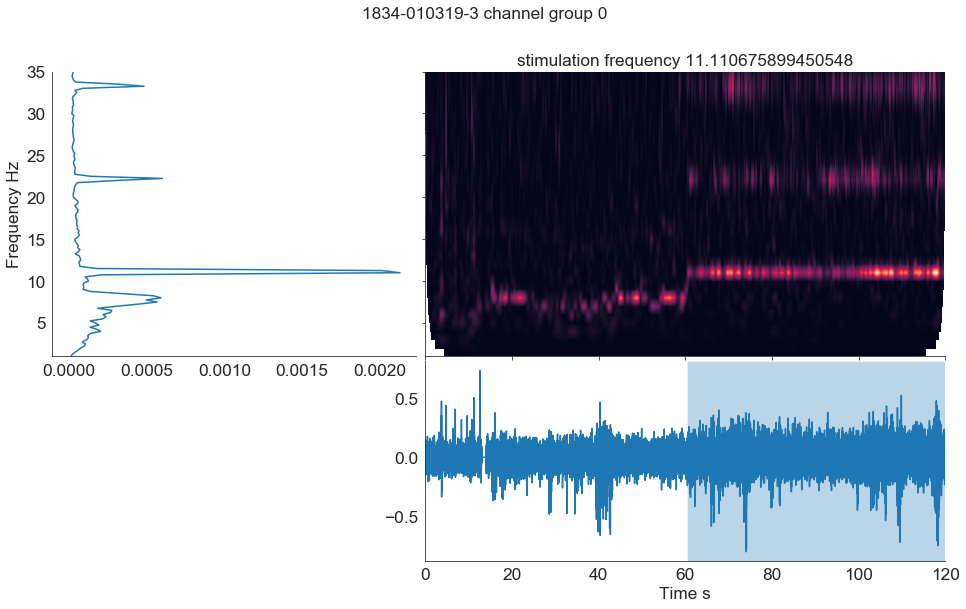

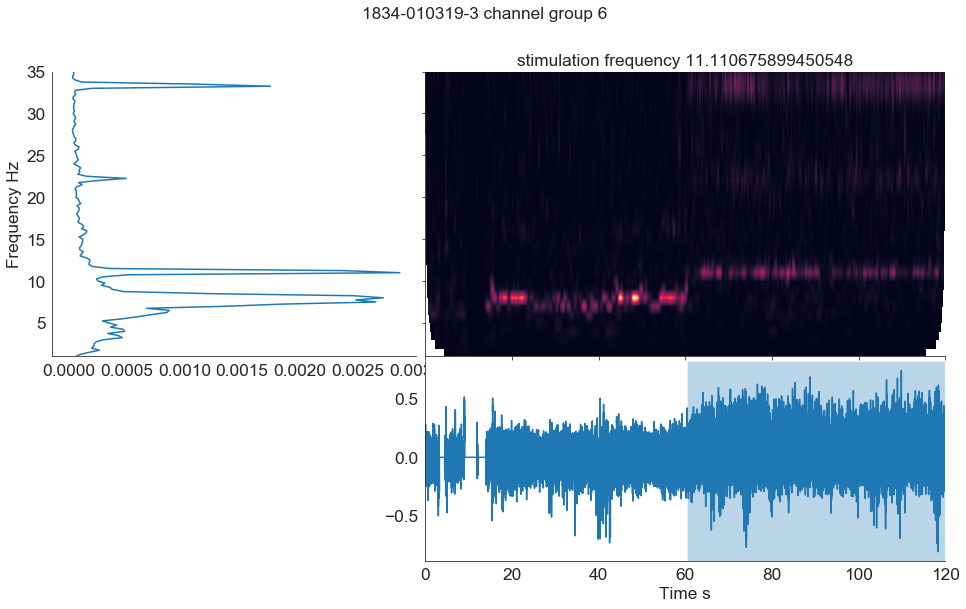

In [254]:
def plot_all_tfr():
    epochs = dp.load_epochs(data_path)
    for channel_id in [0,6]:
        anas = dp.load_lfp(data_path, channel_id)
        fig = plt.figure(figsize=(16,9))
        tfr(anas, epochs, fig, t_start=0, t_stop=120, f_start=1, f_stop=35, threshold=.9)
        despine()
        fig.suptitle('{} channel group {}'.format(action_id, channel_id))
plot_all_tfr()

No spikes in channel group 2


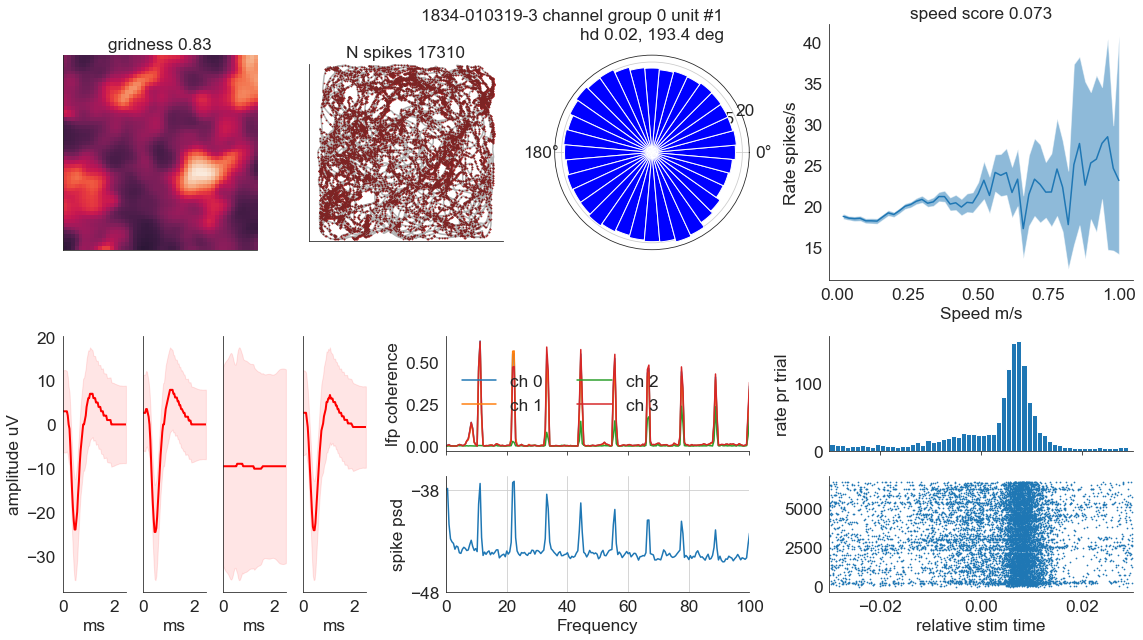

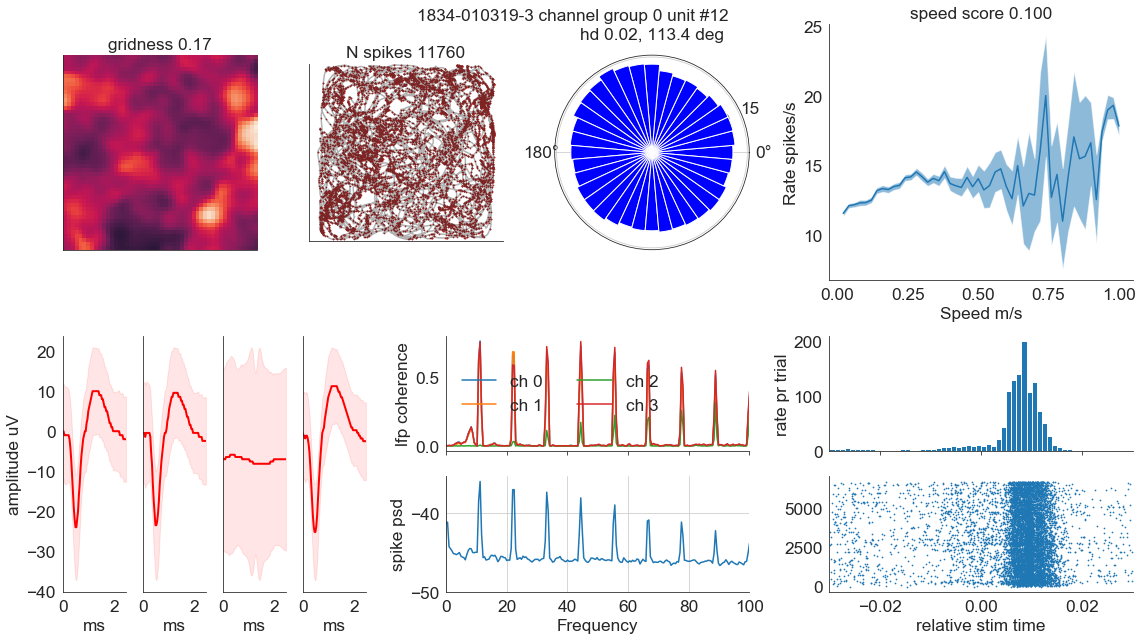

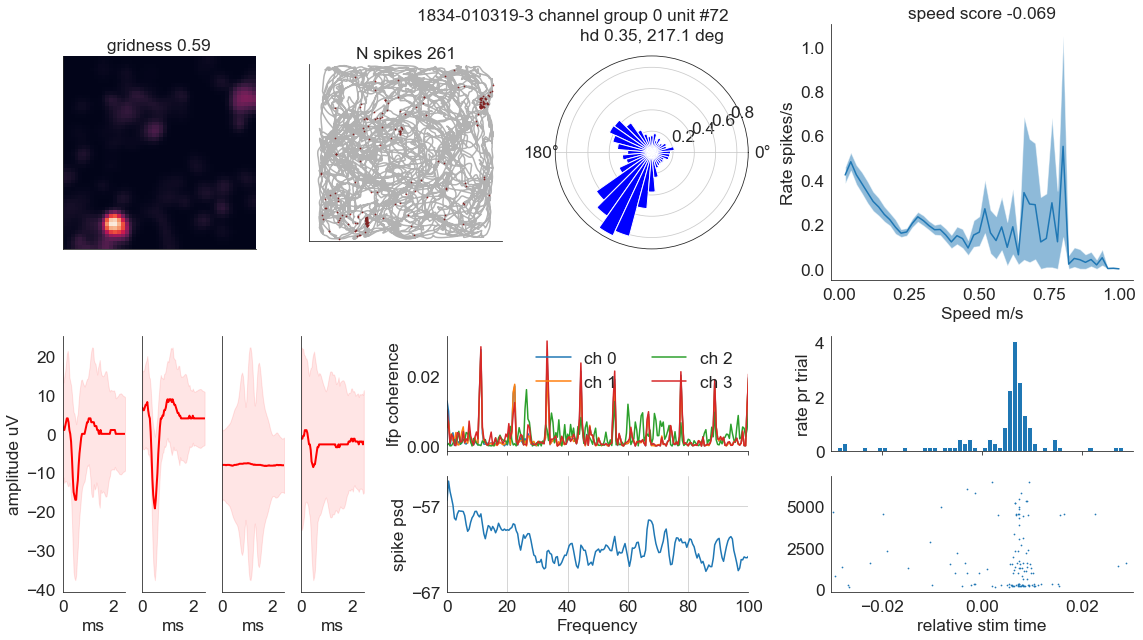

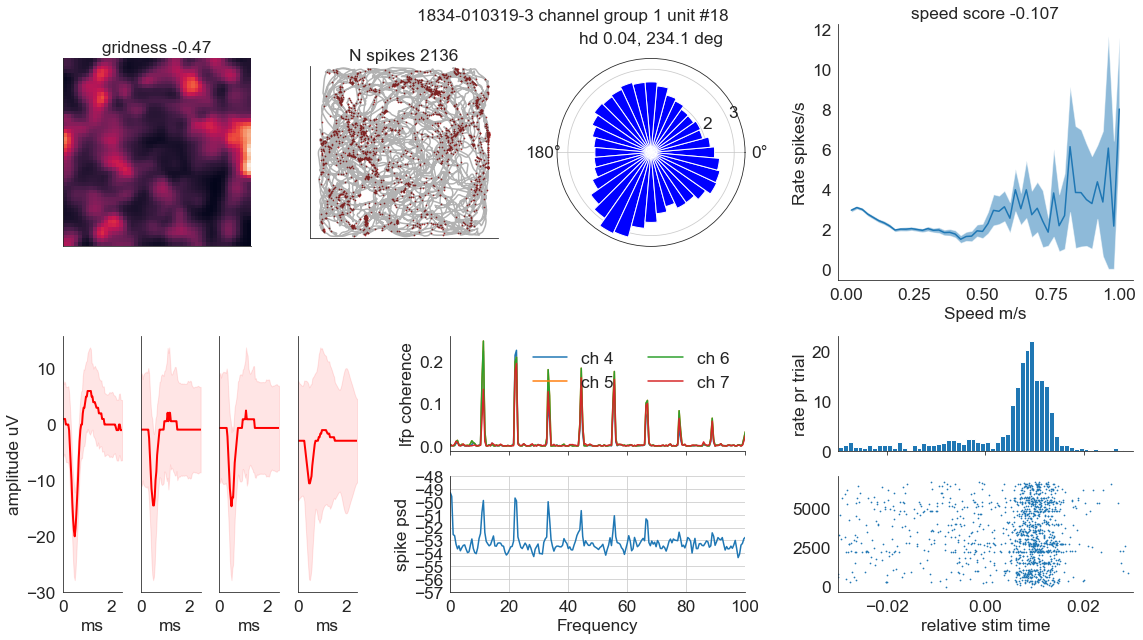

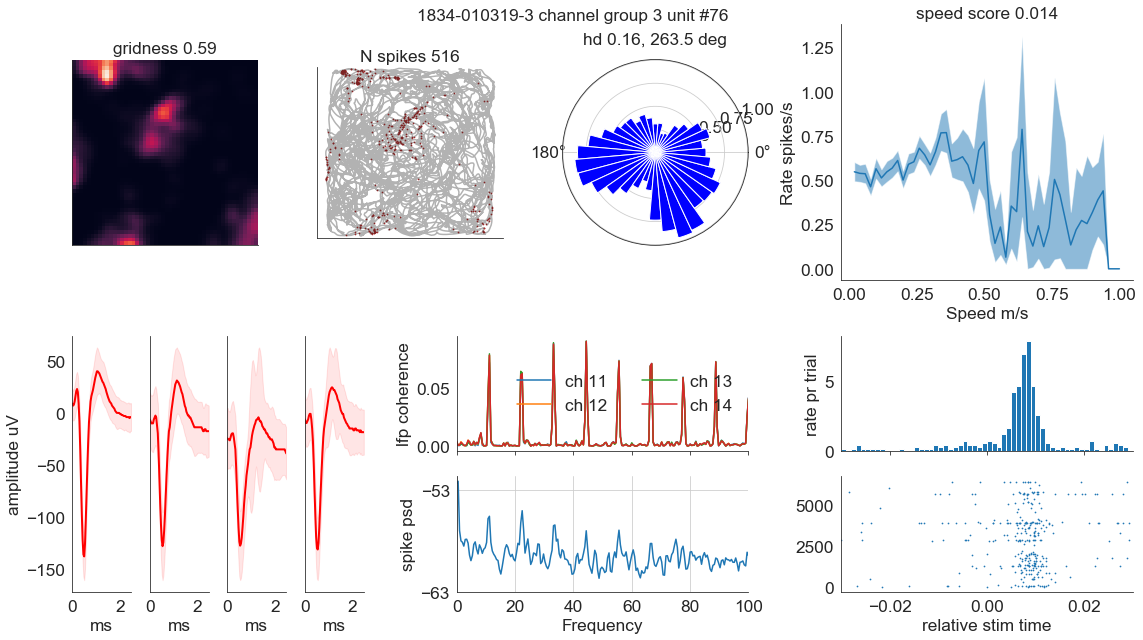

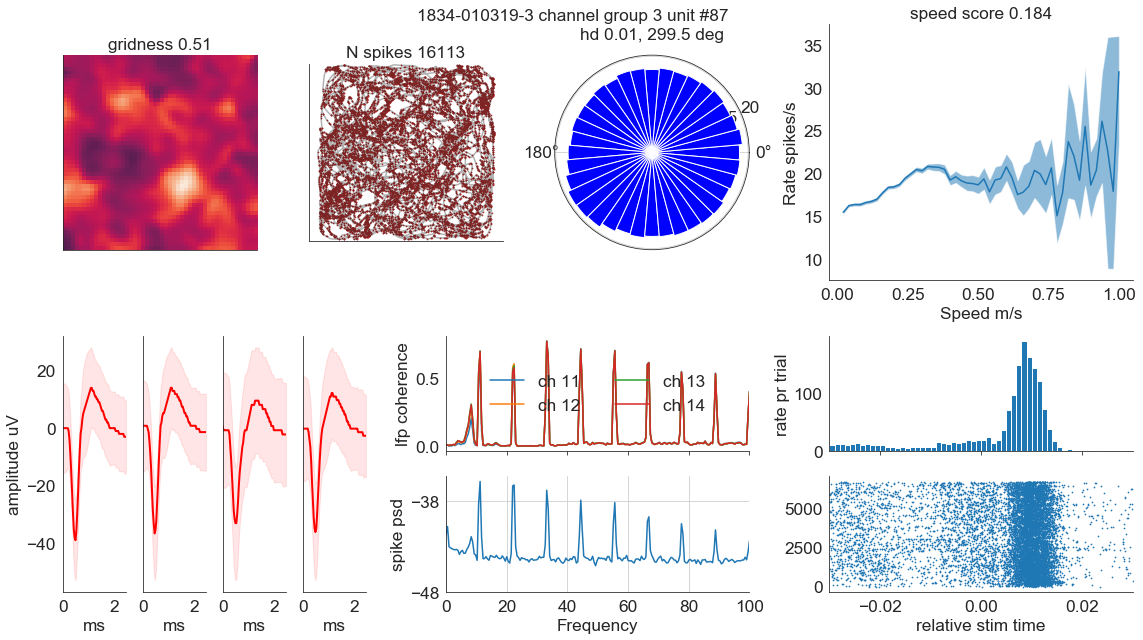

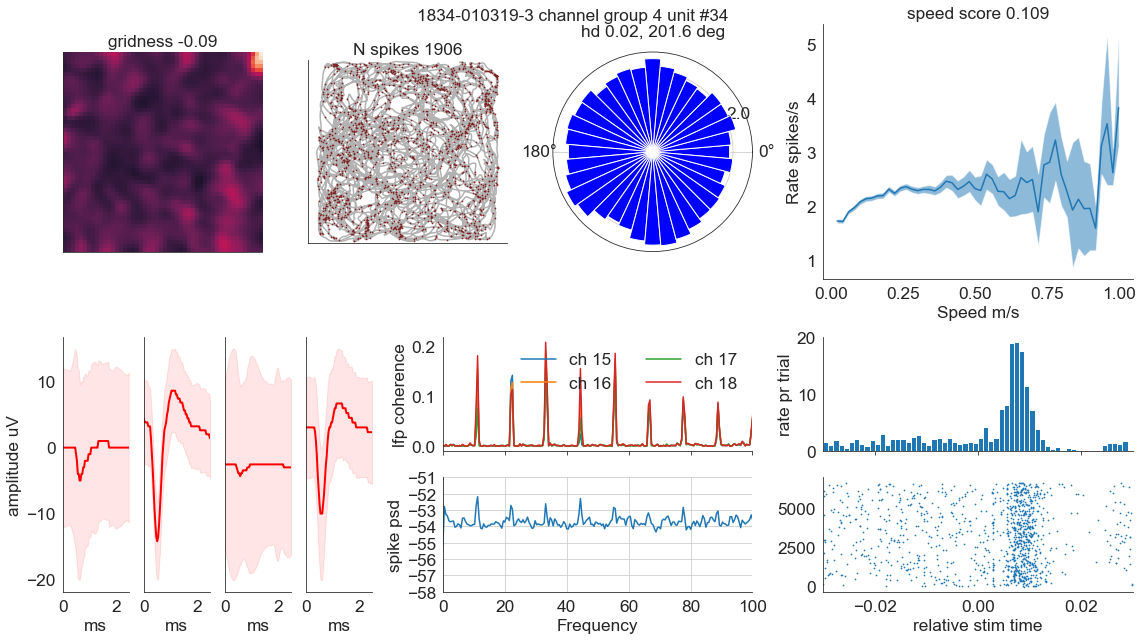

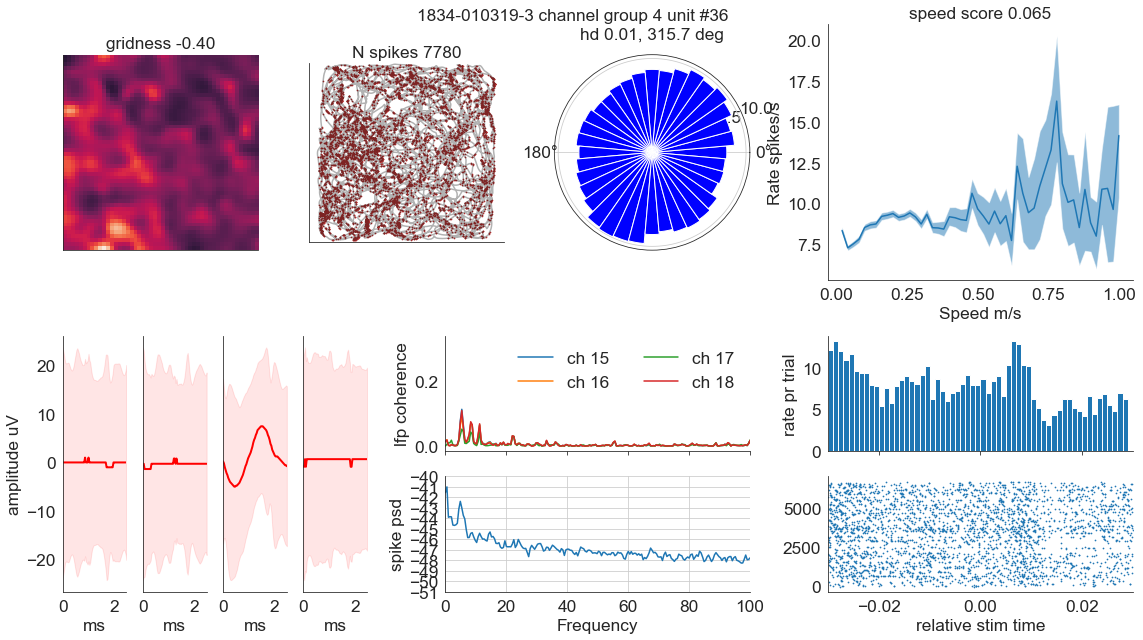

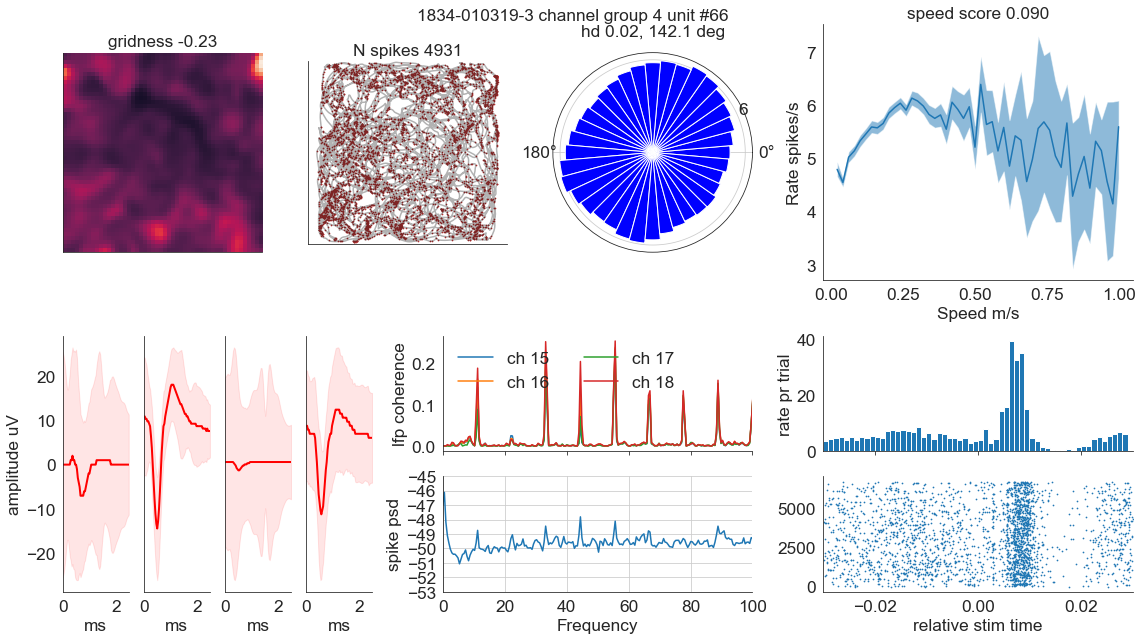

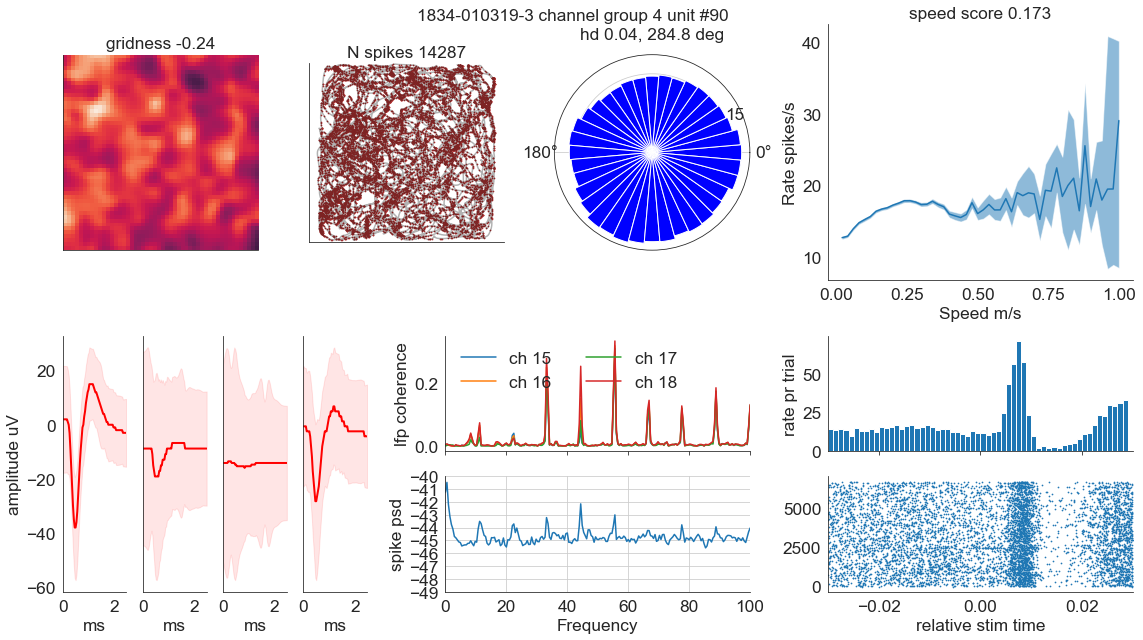

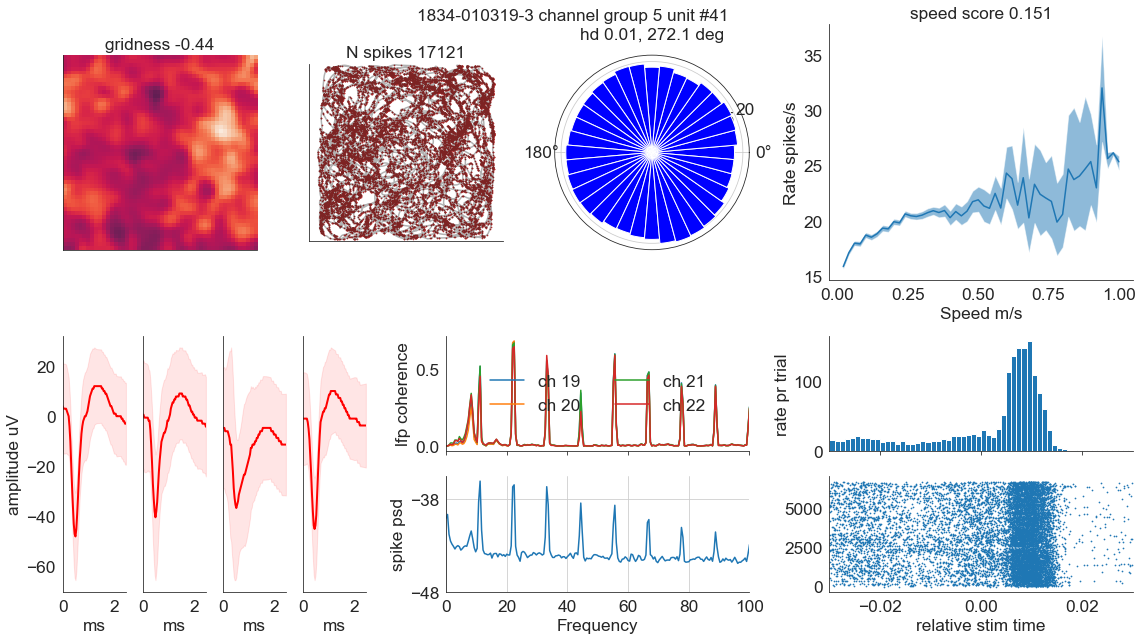

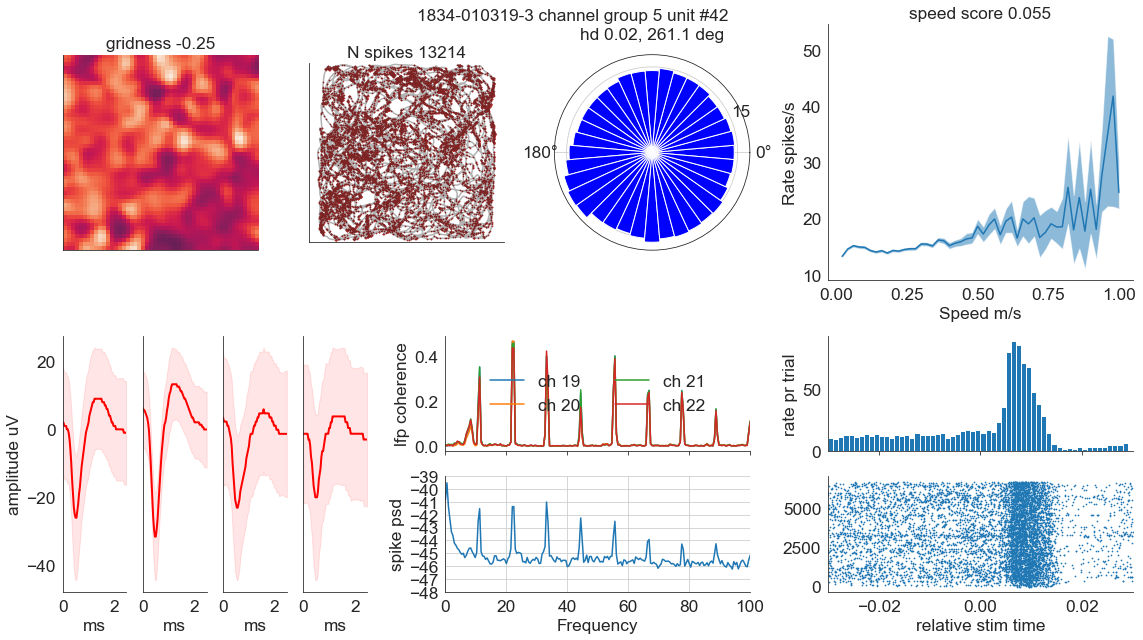

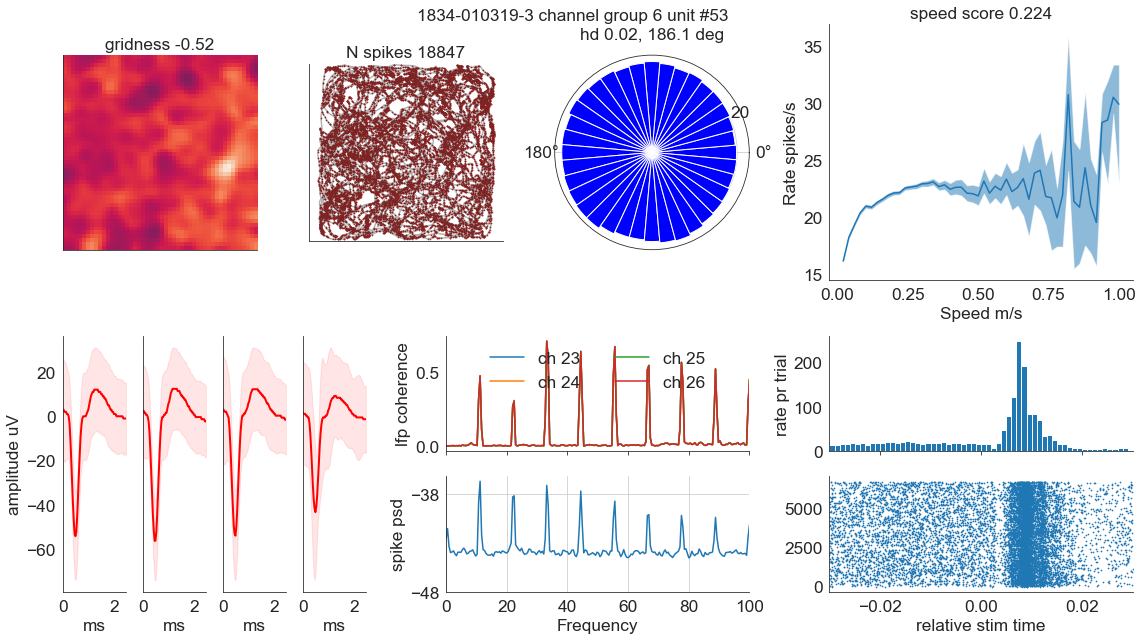

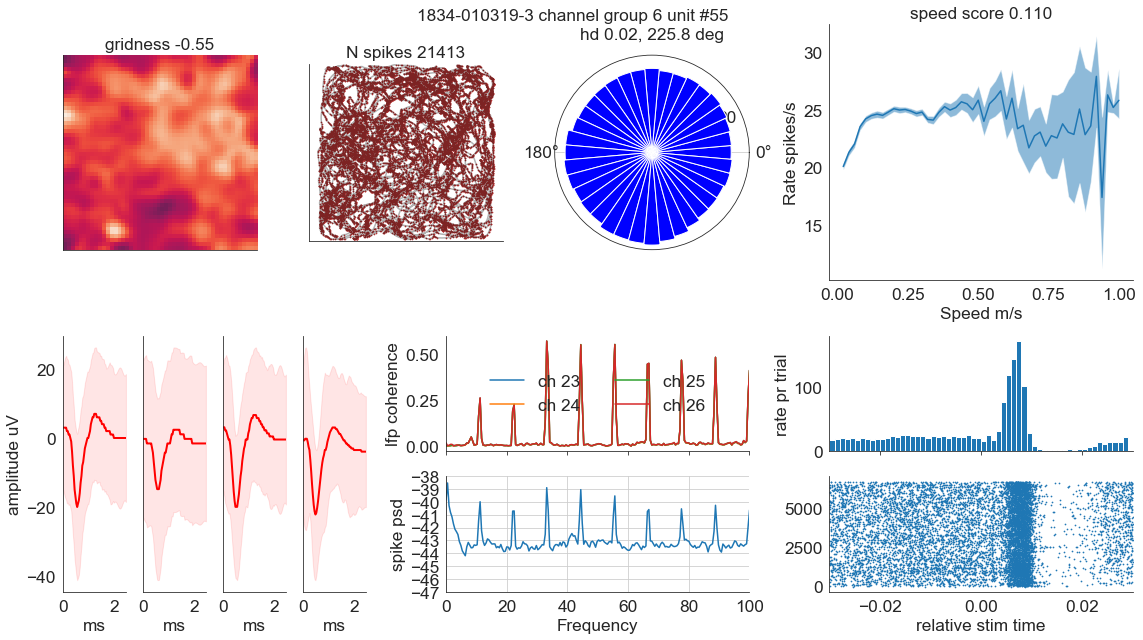

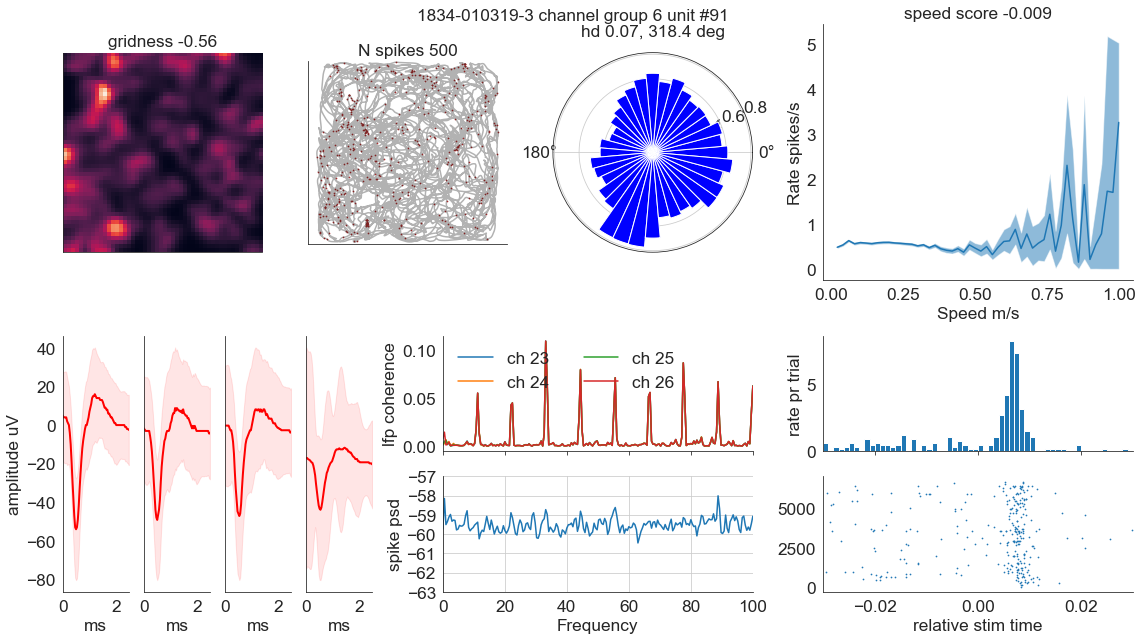

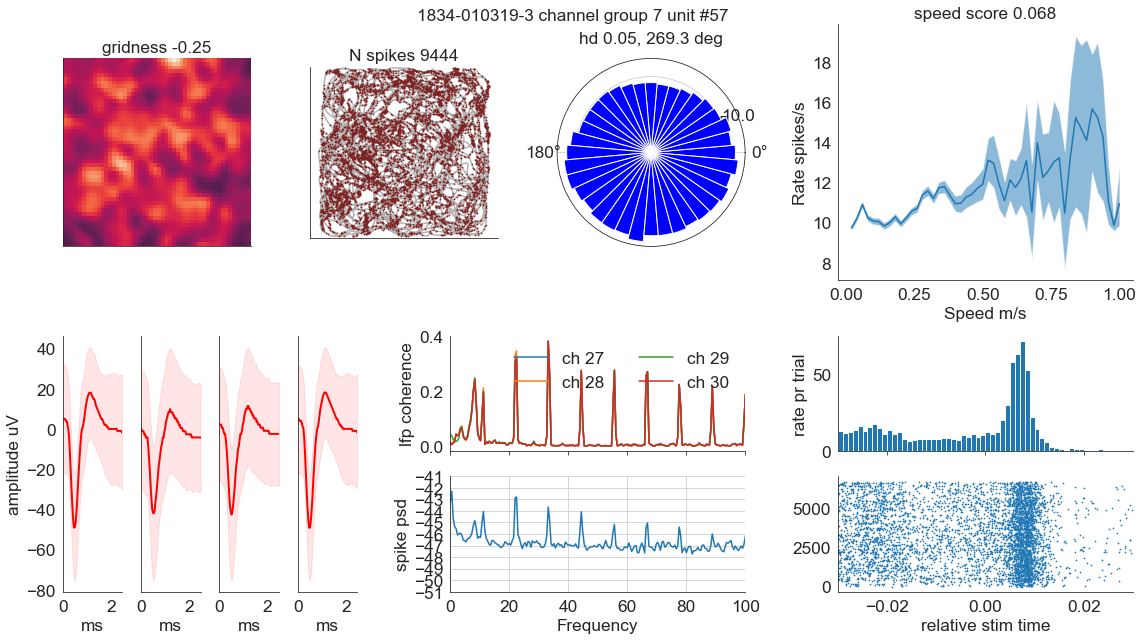

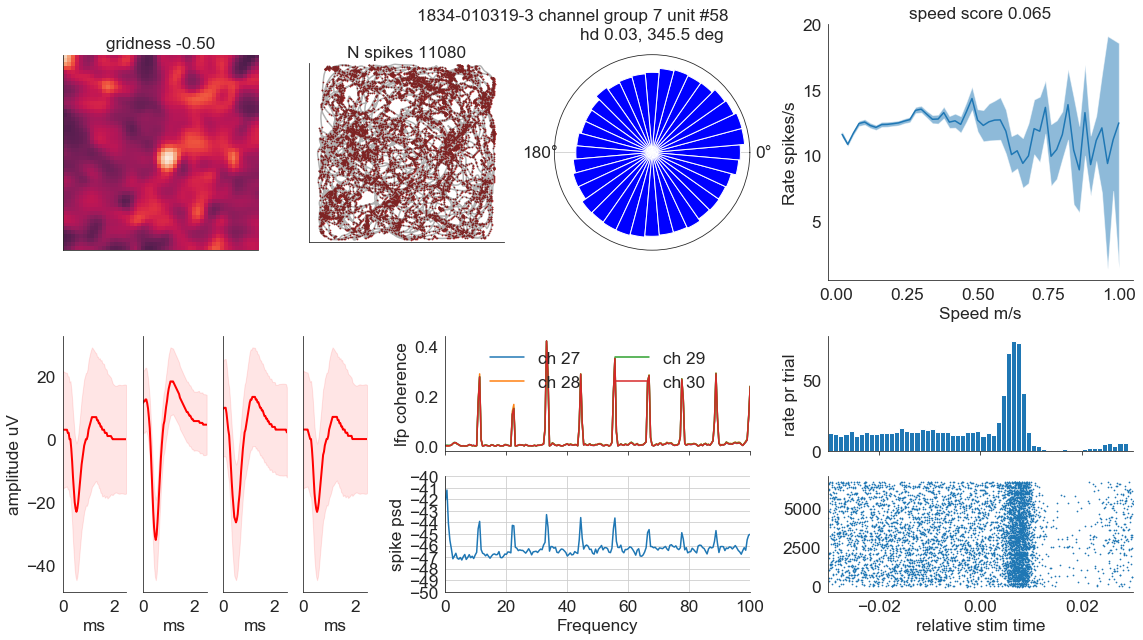

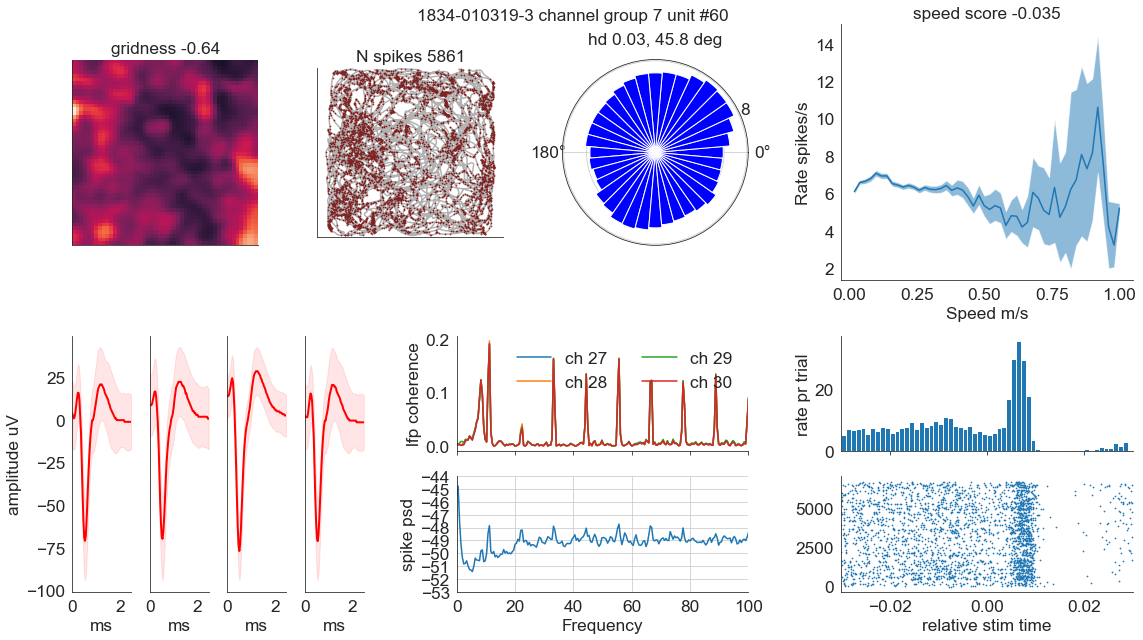

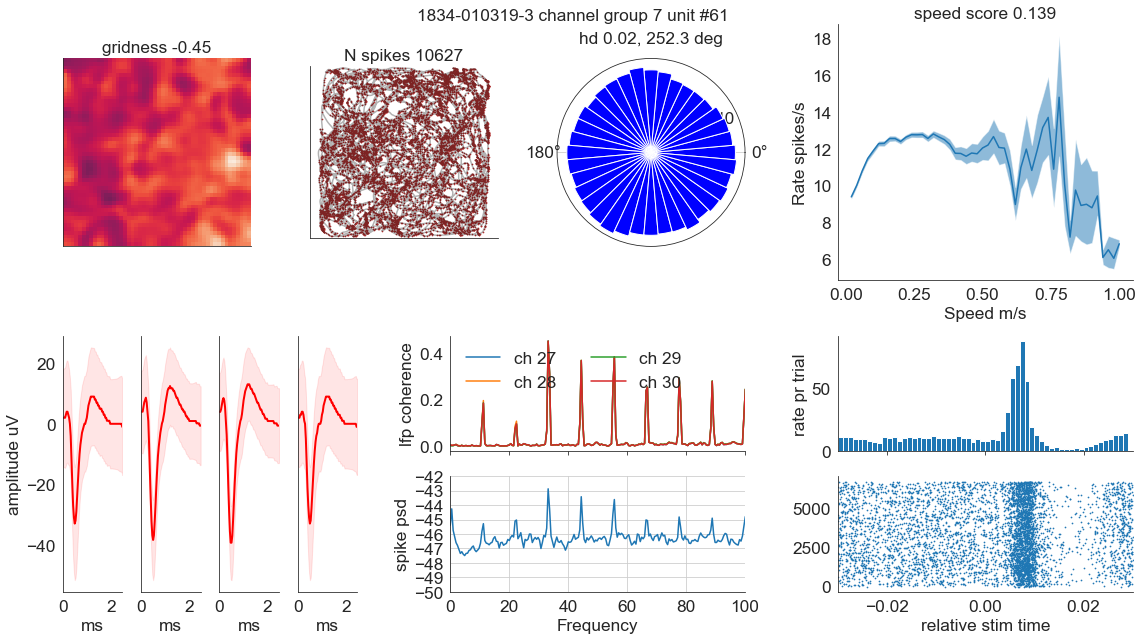

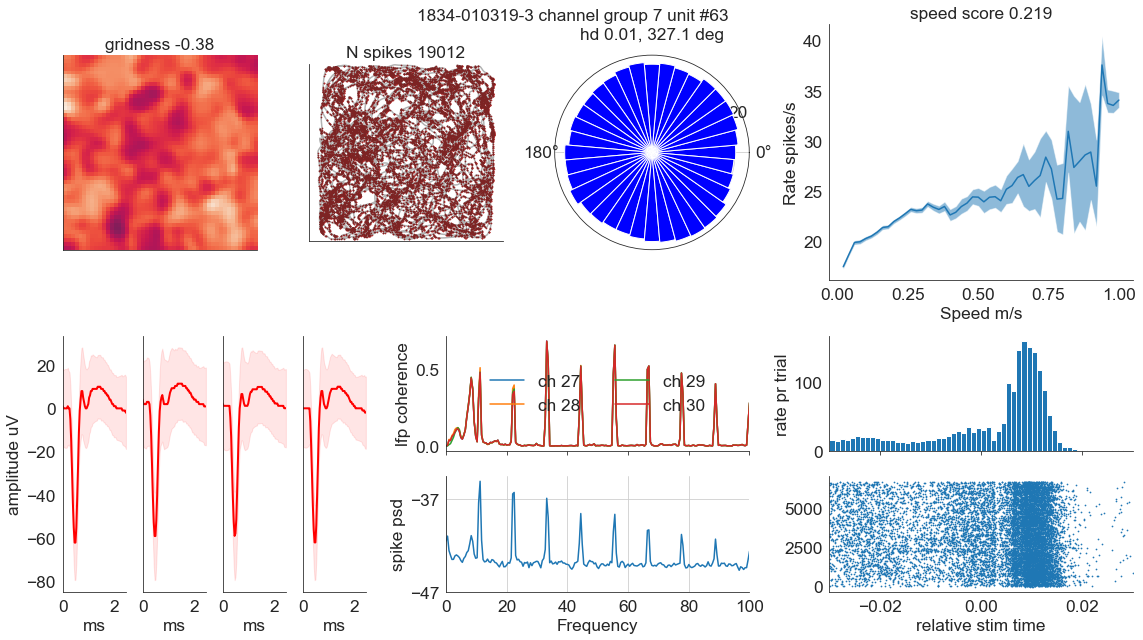

In [256]:
def plot_all_cells():
    epochs = dp.load_epochs(data_path)
    
    x, y, t, speed = dp.load_tracking(
        data_path, position_sampling_rate, position_low_pass_frequency)
    a, at = dp.load_head_direction(
        data_path, position_sampling_rate, position_low_pass_frequency)

    # select random times if no stimulation to make rasters
    stim_times = np.linspace(0, t[-1]-.03, 1000) if len(epochs) == 0 else epochs[0].times.magnitude
    stim_freq = 1 / np.median(np.diff(stim_times))
    if stim_freq < 35 and stim_freq > 29:
        stim_cut = 0.015
    else:
        stim_cut = 0.030
        
    for channel_id in channel_ids:
        anas = dp.load_lfp(data_path, channel_id) # TODO remove artifacts
        spike_trains = dp.load_spiketrains(data_path, channel_id, load_waveforms=True)

        if len(spike_trains) == 0:
            print('No spikes in channel group {}'.format(channel_id))
            continue

        spike_trains = dp.sort_by_cluster_id(spike_trains)
        for spike_times in spike_trains:
            fig = plt.figure(figsize=(16,9))
            gs = gridspec.GridSpec(2, 3)
            fig.suptitle('{} channel group {} {}\n'.format(
                action_id, spike_times.annotations['group_id'], spike_times.annotations['name']))
            
            spatial(
                x, y, t, spike_times, a, at, binsize, smoothing, 
                fig, gs[0,:2], t_start=None, t_stop=None)
                        
            speedcor(
                speed, t, spike_times, min_speed, max_speed, binsize, 
                fig, gs[0, 2], t_start=None, t_stop=None)
            
            waveform(
                spike_times, fig, gs[1,0], t_start=None, t_stop=None)
            
            spikelfp(
                spike_times, anas, fig, gs[1,1], # consider setting t_start to 60
                t_start=None, t_stop=None, f_start=0, f_stop=100)
            
            psth(
                spike_times, stim_times, fig, gs[1,2], pre_stim=-stim_cut, post_stim=stim_cut, binsize=0.001, 
                t_start=None, t_stop=None)
            
            despine()
            plt.tight_layout()
            
plot_all_cells()